# Project Title
### Data Engineering Capstone Project

#### Project Summary
This project makes use of four datasets. World Temperature Data, U.S. City Demographic Data, Airport Code Table and I94 Immigration Data.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
! pip install missingno
import data_exploration_tools as detools
import pandas as pd
import configparser
import os
import logging
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType, LongType, IntegerType
from pyspark.sql.functions import udf, col, lit, year, month, upper, to_date
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [2]:
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
### Purpose of the Final Data Model

The **final data model** is designed to support **immigration analytics** by providing a well-structured relational database that enables efficient querying and analysis of immigration-related data. It organizes data from various sources such as immigration records, demographic data, temperature data, and airline data into fact and dimension tables, creating a **star schema**. This star schema simplifies reporting and analysis, making it easier for users (analysts, data scientists, and policymakers) to answer immigration-related questions quickly and accurately.

#### How Users Can Use the Data Model

1. **Data Exploration & Reporting:**
   - Users can easily explore and generate reports on immigrant inflows and outflows across different periods, locations, or categories.
   - Analysts can visualize key metrics like the number of immigrants arriving by country, port of entry, state, or visa type.

2. **Trend Analysis:**
   - Users can track immigration trends over time, comparing metrics such as the number of immigrants per year, month, or specific periods.
   - Historical data can be used to understand how political, social, or environmental factors (like temperature) influence immigration patterns.

3. **Demographic Insights:**
   - Users can gain insights into the demographics of immigrants, such as age, gender, or the foreign-born population in specific cities or states.
   - The data model links immigration data with demographic data, enabling users to analyze the effect of immigration on local population dynamics.

4. **Operational Efficiency:**
   - Users can assess the operational efficiency of different ports of entry or airlines, analyzing flight numbers, arrival and departure dates, and transport modes.
   - Visa category and transport mode insights can help governments plan for resource allocation at airports or visa offices.

5. **Policy Evaluation:**
   - Policymakers can analyze the impact of different visa types and immigration policies on immigration flows. For instance, they can evaluate how different visa categories impact the total number of immigrants arriving from specific countries.
   - It also enables governments to assess how immigration patterns align with or deviate from national or state-level immigration policies.

#### Questions That Can Be Answered Using This Data Model

1. **Immigrant Inflow Trends:**
   - How many immigrants entered the U.S. each year/month? 
   - Which U.S. states see the highest number of immigrants arriving?
   - How has immigration changed from one year to the next?

2. **Immigration by Country:**
   - Which countries do most immigrants come from?
   - How do immigration patterns from specific countries differ by visa type or state?
   - Which countries have the highest number of citizens using specific visa categories (e.g., work, student, tourist)?

3. **Demographic Analysis:**
   - What is the gender distribution of immigrants arriving in the U.S.?
   - What is the age distribution of immigrants, and how does this vary across countries or visa types?
   - What is the foreign-born population in different U.S. cities and states?

4. **Mode of Transportation & Port of Entry:**
   - Which ports of entry (airports, seaports) receive the most immigrants?
   - What transport modes (air, land, sea) are most commonly used by immigrants?
   - Which airlines are most frequently used by immigrants arriving in the U.S.?

5. **Visa Type Insights:**
   - What are the most common visa categories used by immigrants from different countries?
   - How many immigrants arrive on temporary work visas, student visas, or tourist visas each year?
   - How do visa categories correlate with the length of stay (arrival and departure dates) in the U.S.?

6. **Temperature and Immigration:**
   - Is there any correlation between temperature (average temperature in origin country) and immigration patterns?
   - How do temperature trends in the U.S. or immigrants’ countries of origin relate to changes in immigration volume?

7. **Population Impact:**
   - How does the arrival of immigrants affect the total population and demographics of specific U.S. cities?
   - What percentage of the population in a given city or state consists of foreign-born immigrants?
   - How do immigration patterns influence the veteran or workforce demographics in U.S. states or cities?

#### Summary of the Data Model Use Cases

The data model provides an integrated view of immigration data, temperature, demographics, airline information, and visa categories. It is a powerful tool for:

- **Policymakers** to evaluate immigration policies and their impact.
- **Analysts** to discover trends and patterns in immigration flows, providing insights for resource planning and infrastructure management.
- **Data scientists** to conduct advanced analytics, such as predicting future immigration patterns based on historical trends and external factors (e.g., temperature, policy changes).
- **Government agencies** to monitor and analyze immigration-related operations, ensuring efficient border management and visa processing.

By offering comprehensive data and the ability to perform complex queries, the model supports **data-driven decision-making** in areas related to immigration management, policy formulation, and national security.

#### Describe and Gather Data 


- World Temperature Data loaded as temperature_df: 
    - This dataset contains temperature data of various cities from the 1700’s to 2013. 
    - This data comes from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data. 
    - The data is all about the average temperature and the average temperature uncertainity in a day of a city with the country name and the coordinates (latitude and longitude).
    

- U.S. City Demographic Data loaded as demographics_df: 
    - This data is about the demographics of US cities. 
    - This data comes from https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/.
    - This dataset includes information on the male female population of all US cities with states names and includes median age, number of veterans, foreign born, average house hold size and race. 
    
    
- Airport Code Table loaded as airport_df: 
    - This table contains the airport codes for the airports in respective cities. 
    - This data comes from https://datahub.io/core/airport-codes#data.
    - This data consists of airport type, name, elevation in feet, country, region municipality gps code, iata code, local code and the coordinates.


- i94 Immigration Sample Data loaded as immigration_df: 
    - The sample data of immigration records from the US National Tourism and Trade Office. 
    - This data comes from https://travel.trade.gov/research/reports/i94/historical/2016.html.
    - This data has infomation on the immigrants such as their year and month of birth, country of birth, residence, port of admission, arrival date, mode of arrival, arrived state, visa status, insurance number, flight number.
    - This data set will be the Fact table in the schema.

#### World Temperature Data 

In [3]:
world_temperature_data = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df_raw = pd.read_csv(world_temperature_data)

In [4]:
temperature_df_raw.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### Airport Data 

In [5]:
airport_data = 'airport-codes_csv.csv'
airport_df_raw = pd.read_csv(airport_data)

In [6]:
airport_df_raw.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### U.S. City Demographic Data

In [7]:
us_cities_demographics_data = 'us-cities-demographics.csv'
demographics_df_raw = pd.read_csv(us_cities_demographics_data, sep = ';')

In [8]:
demographics_df_raw.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Immigration Data 

In [9]:
immigration_data = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df_raw = pd.read_sas(immigration_data, 'sas7bdat', encoding="ISO-8859-1")

In [10]:
immigration_df_raw.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,37.0,2.0,1.0,NaN,NaN,NaN,T,NaN,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,NaN,G,NaN,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,NaN,NaN,T,O,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,NaN,NaN,O,O,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,20160401,NaN,NaN,O,O,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


### Step 2: Explore and Assess the Data
##### 2.1 Explore the Data 
Identifying data quality issues, like missing values, duplicate data, etc.

##### Temperature Dataframe



Dataframe Information 

Number of Rows: 8599212
Number of Columns: 7 

Column Headers: ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude'] 

Data Types:
dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object


Missing Values Information 

Column dt has 0 missing values.
Column AverageTemperature has 364130 missing values.
Column AverageTemperatureUncertainty has 364130 missing values.
Column City has 0 missing values.
Column Country has 0 missing values.
Column Latitude has 0 missing values.
Column Longitude has 0 missing values.


Duplicated Rows Information 

Number of duplicate rows: 0


Unique Values Information 

Column dt has 3239 unique values.
['1743-11-01' '1743-12-01' '1744-01-01

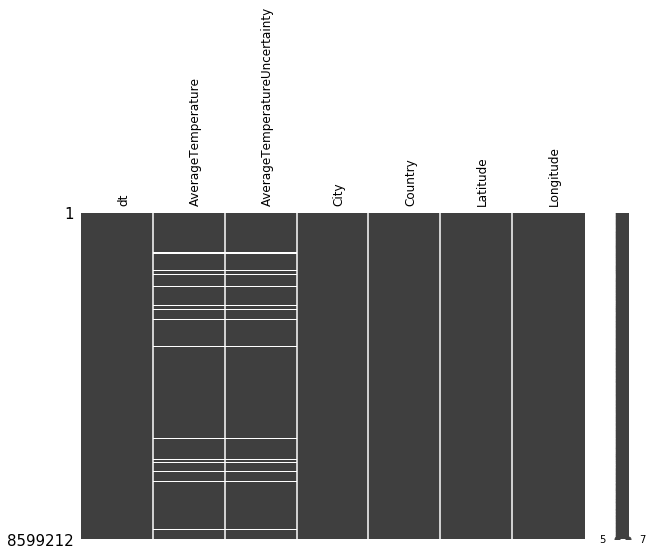

In [11]:
detools.print_dataframe_info(temperature_df_raw)

##### Airport Dataframe



Dataframe Information 

Number of Rows: 55075
Number of Columns: 12 

Column Headers: ['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country', 'iso_region', 'municipality', 'gps_code', 'iata_code', 'local_code', 'coordinates'] 

Data Types:
ident            object
type             object
name             object
elevation_ft    float64
continent        object
iso_country      object
iso_region       object
municipality     object
gps_code         object
iata_code        object
local_code       object
coordinates      object
dtype: object


Missing Values Information 

Column ident has 0 missing values.
Column type has 0 missing values.
Column name has 0 missing values.
Column elevation_ft has 7006 missing values.
Column continent has 27719 missing values.
Column iso_country has 247 missing values.
Column iso_region has 0 missing values.
Column municipality has 5676 missing values.
Column gps_code has 14045 missing values.
Column iata_code has 45886 missing values.
Column 

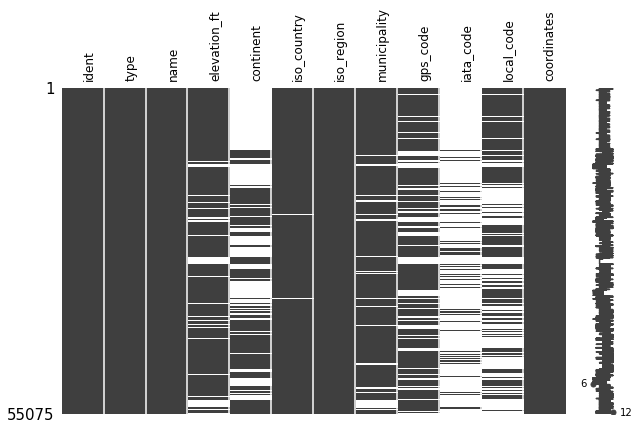

In [12]:
detools.print_dataframe_info(airport_df_raw)

##### Demographic Dataframe



Dataframe Information 

Number of Rows: 2891
Number of Columns: 12 

Column Headers: ['City', 'State', 'Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'State Code', 'Race', 'Count'] 

Data Types:
City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
dtype: object


Missing Values Information 

Column City has 0 missing values.
Column State has 0 missing values.
Column Median Age has 0 missing values.
Column Male Population has 3 missing values.
Column Female Population has 3 missing values.
Column Total Population has 0 missing values.
Column Numbe

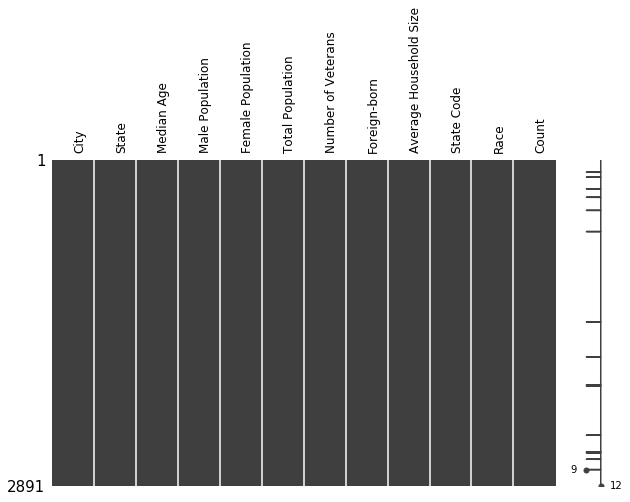

In [13]:
detools.print_dataframe_info(demographics_df_raw)

##### Immigration Dataframe



Dataframe Information 

Number of Rows: 3096313
Number of Columns: 28 

Column Headers: ['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype'] 

Data Types:
cicid       float64
i94yr       float64
i94mon      float64
i94cit      float64
i94res      float64
i94port      object
arrdate     float64
i94mode     float64
i94addr      object
depdate     float64
i94bir      float64
i94visa     float64
count       float64
dtadfile     object
visapost     object
occup        object
entdepa      object
entdepd      object
entdepu      object
matflag      object
biryear     float64
dtaddto      object
gender       object
insnum       object
airline      object
admnum      float64
fltno        object
visatype     object
dtype: object


Missing Values Informatio

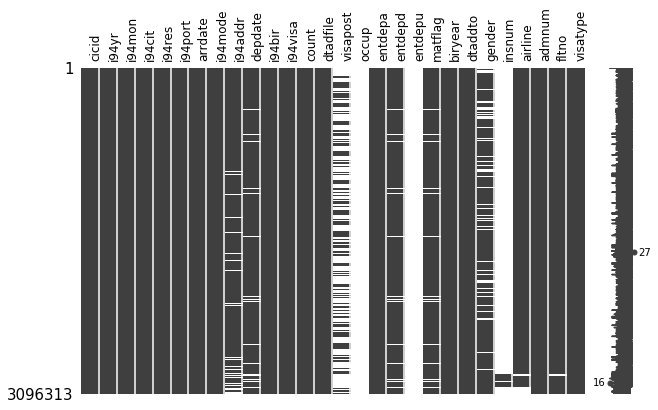

In [14]:
detools.print_dataframe_info(immigration_df_raw)

#### 2.2 Cleaning Steps

##### Temperature Dataframe

In [15]:
# Dropp columns with more than 90% of missing values
temperature_df = detools.drop_missing_fields(temperature_df_raw, df_name='temperature_df')

# Dropping the 'latitude' and 'longitude' columns from temperature_df
temperature_df.drop(columns=['Latitude', 'Longitude'], inplace=True)

# Ensure the 'dt' column is in datetime format
temperature_df['dt'] = pd.to_datetime(temperature_df['dt'])

# Extract the year and month into separate columns
temperature_df['Year'] = temperature_df['dt'].dt.year
temperature_df['Month'] = temperature_df['dt'].dt.month

# Dropping the dt column
temperature_df.drop(columns='dt', inplace=True)

# Display the updated DataFrame
print('-- Temperature Dataframe After Cleaning -- ')
temperature_df.head()

-- Dataframe Cleaning -- 

Creating a copy of raw dataframe to begin with.
temperature_df has 7 fields prior to cleaning.
temperature_df has 8599212 rows prior to cleaning.
Checking for fields in temperature_df that have more than 90.0% of missing data and will be dropped.
Dropping missing fields complete.
temperature_df now has 7 fields after cleaning.
temperature_df now has 8599212 rows after cleaning. 

-- Temperature Dataframe After Cleaning -- 


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Year,Month
0,6.068,1.737,Århus,Denmark,1743,11
1,NaN,NaN,Århus,Denmark,1743,12
2,NaN,NaN,Århus,Denmark,1744,1
3,NaN,NaN,Århus,Denmark,1744,2
4,NaN,NaN,Århus,Denmark,1744,3


##### Airport Dataframe

In [16]:
# Dropp columns with more than 90% of missing values
airport_df = detools.drop_missing_fields(airport_df_raw, df_name='airport_df')

# Dropping the column with duplicate information
airport_df.drop(columns=['coordinates', 'continent', 'iata_code', 'gps_code', 'local_code'], inplace=True)

# Display the updated DataFrame
print('-- Airport Dataframe After Cleaning -- ')
airport_df.head()

-- Dataframe Cleaning -- 

Creating a copy of raw dataframe to begin with.
airport_df has 12 fields prior to cleaning.
airport_df has 55075 rows prior to cleaning.
Checking for fields in airport_df that have more than 90.0% of missing data and will be dropped.
Dropping missing fields complete.
airport_df now has 12 fields after cleaning.
airport_df now has 55075 rows after cleaning. 

-- Airport Dataframe After Cleaning -- 


,ident,type,name,elevation_ft,iso_country,iso_region,municipality
0,00A,heliport,Total Rf Heliport,11.0,US,US-PA,Bensalem
1,00AA,small_airport,Aero B Ranch Airport,3435.0,US,US-KS,Leoti
2,00AK,small_airport,Lowell Field,450.0,US,US-AK,Anchor Point
3,00AL,small_airport,Epps Airpark,820.0,US,US-AL,Harvest
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,US,US-AR,Newport


##### Demographic Dataframe

In [17]:
# Dropp columns with more than 90% of missing values
demographics_df = detools.drop_missing_fields(demographics_df_raw, df_name='demographics_df')

# Pivot the DataFrame to make 'Race' the columns and 'Count' the values
demographics_df = demographics_df.pivot_table(
    index=['City', 'State', 'Median Age', 'Male Population', 'Female Population', 'Total Population', 
           'Number of Veterans', 'Foreign-born', 'Average Household Size', 'State Code'], 
    columns='Race', 
    values='Count',
    aggfunc='sum', 
    fill_value=0  
    )

# Reset index to make 'City', 'State', etc., regular columns again
demographics_df = demographics_df.reset_index()

# Convert all float columns to int64
float_columns = demographics_df.select_dtypes(include='float64').columns

# Remove 'Median Age' and 'Average Household Size' from the list of float columns
columns_to_convert = float_columns.difference(['Median Age', 'Average Household Size'])

# Convert the remaining float columns to int64
demographics_df[columns_to_convert] = demographics_df[columns_to_convert].astype('int64')

# Print the transformed DataFrame
print('-- Demographics Dataframe After Cleaning -- ')
demographics_df.head()

-- Dataframe Cleaning -- 

Creating a copy of raw dataframe to begin with.
demographics_df has 12 fields prior to cleaning.
demographics_df has 2891 rows prior to cleaning.
Checking for fields in demographics_df that have more than 90.0% of missing data and will be dropped.
Dropping missing fields complete.
demographics_df now has 12 fields after cleaning.
demographics_df now has 2891 rows after cleaning. 

-- Demographics Dataframe After Cleaning -- 


Race,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,American Indian and Alaska Native,Asian,Black or African-American,Hispanic or Latino,White
0,Abilene,Texas,31.3,65212,60664,125876,9367,8129,2.64,TX,1813,2929,14449,33222,95487
1,Akron,Ohio,38.1,96886,100667,197553,12878,10024,2.24,OH,1845,9033,66551,3684,129192
2,Alafaya,Florida,33.5,39504,45760,85264,4176,15842,2.94,FL,0,10336,6577,34897,63666
3,Alameda,California,41.4,37747,40867,78614,4504,18841,2.52,CA,1329,27984,7364,8265,44232
4,Albany,Georgia,33.3,31695,39414,71109,5409,861,2.38,GA,445,650,53440,1783,17160


##### Immigration Dataframe

In [18]:
# Dropp columns with more than 90% of missing values
immigration_df = detools.drop_missing_fields(immigration_df_raw, df_name='immigration_df')

# Convert SAS dates to proper date format
immigration_df['arrdate'] = pd.to_timedelta(immigration_df['arrdate'], unit='D') + pd.Timestamp('1960-01-01')
immigration_df['depdate'] = pd.to_timedelta(immigration_df['depdate'], unit='D') + pd.Timestamp('1960-01-01')

# Convert the float columns to int64
columns_to_convert = ['cicid','i94yr','i94mon','i94cit','i94res','i94visa','count','admnum']
immigration_df[columns_to_convert] = immigration_df[columns_to_convert].astype('int64')

# Print the transformed DataFrame
print('-- Immigration Dataframe After Cleaning -- ')
immigration_df.head()

-- Dataframe Cleaning -- 

Creating a copy of raw dataframe to begin with.
immigration_df has 28 fields prior to cleaning.
immigration_df has 3096313 rows prior to cleaning.
Checking for fields in immigration_df that have more than 90.0% of missing data and will be dropped.
Dropping column 'occup' with 99.74% missing data
Dropping column 'entdepu' with 99.99% missing data
Dropping column 'insnum' with 96.33% missing data
Dropping missing fields complete.
immigration_df now has 25 fields after cleaning.
immigration_df now has 3096313 rows after cleaning. 

-- Immigration Dataframe After Cleaning -- 


,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,6,2016,4,692,692,XXX,2016-04-29,NaN,NaN,NaT,37.0,2,1,NaN,NaN,T,NaN,NaN,1979.0,10282016,NaN,NaN,1897628485,NaN,B2
1,7,2016,4,254,276,ATL,2016-04-07,1.0,AL,NaT,25.0,3,1,20130811,SEO,G,NaN,NaN,1991.0,D/S,M,NaN,3736796330,00296,F1
2,15,2016,4,101,101,WAS,2016-04-01,1.0,MI,2016-08-25,55.0,2,1,20160401,NaN,T,O,M,1961.0,09302016,M,OS,666643185,93,B2
3,16,2016,4,101,101,NYC,2016-04-01,1.0,MA,2016-04-23,28.0,2,1,20160401,NaN,O,O,M,1988.0,09302016,NaN,AA,92468461330,00199,B2
4,17,2016,4,101,101,NYC,2016-04-01,1.0,MA,2016-04-23,4.0,2,1,20160401,NaN,O,O,M,2012.0,09302016,NaN,AA,92468463130,00199,B2


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

In [19]:
# Selecting specific columns from the 'immigration_df' DataFrame and creating a new DataFrame 'fact_immigration'
fact_immigration = immigration_df[['cicid', 'i94yr', 'i94mon', 'i94port', 'i94addr', 'arrdate', 'depdate', 'i94mode', 'i94visa']]

# Renaming the columns in the 'fact_immigration' DataFrame to be more descriptive and consistent
fact_immigration.columns = ['cic_id', 'arrival_year', 'arrival_month', 'arrival_port_code', 'arrival_state_code', 'arrival_date',
                            'departure_date', 'transport_mode_code', 'visa_code']

# Display the DataFrame
fact_immigration.head(5)

,cic_id,arrival_year,arrival_month,arrival_port_code,arrival_state_code,arrival_date,departure_date,transport_mode_code,visa_code
0,6,2016,4,XXX,NaN,2016-04-29,NaT,NaN,2
1,7,2016,4,ATL,AL,2016-04-07,NaT,1.0,3
2,15,2016,4,WAS,MI,2016-04-01,2016-08-25,1.0,2
3,16,2016,4,NYC,MA,2016-04-01,2016-04-23,1.0,2
4,17,2016,4,NYC,MA,2016-04-01,2016-04-23,1.0,2


In [20]:
# Selecting specific columns from the 'immigration_df' DataFrame and creating a new DataFrame 'dim_immigrants'
dim_immigrants = immigration_df[['cicid', 'i94cit', 'i94res', 'biryear', 'gender']]

# Renaming the columns in the 'dim_immigrants' DataFrame to be more descriptive and consistent
dim_immigrants.columns = ['cic_id', 'citizen_country', 'residence_country', 'birth_year', 'gender']

# Display the DataFrame
dim_immigrants.head()

,cic_id,citizen_country,residence_country,birth_year,gender
0,6,692,692,1979.0,NaN
1,7,254,276,1991.0,M
2,15,101,101,1961.0,M
3,16,101,101,1988.0,NaN
4,17,101,101,2012.0,NaN


In [21]:
# Selecting specific columns from the 'immigration_df' DataFrame and creating a new DataFrame 'dim_immi_airline'
dim_immi_airline = immigration_df[['cicid', 'airline', 'admnum', 'fltno', 'visatype']]

# Renaming the columns in the 'dim_immi_airline' DataFrame to be more descriptive and consistent
dim_immi_airline.columns = ['cic_id', 'airline', 'admin_num', 'flight_number', 'visa_type']

# Display the DataFrame
dim_immi_airline.head(5)

,cic_id,airline,admin_num,flight_number,visa_type
0,6,NaN,1897628485,NaN,B2
1,7,NaN,3736796330,00296,F1
2,15,OS,666643185,93,B2
3,16,AA,92468461330,00199,B2
4,17,AA,92468463130,00199,B2


In [22]:
# Selecting specific columns from the 'temperature_df' DataFrame and creating a new DataFrame 'dim_temperature'
dim_temperature = temperature_df[temperature_df['Country'] == 'United States'].reset_index(drop=True)

# Renaming the columns in the 'dim_temperature' DataFrame to be more descriptive and consistent
dim_temperature.columns = ['avg_temp', 'avg_temp_uncertnty', 'city', 'country', 'year', 'month']

# Display the DataFrame
dim_temperature.head()

,avg_temp,avg_temp_uncertnty,city,country,year,month
0,2.101,3.217,Abilene,United States,1820,1
1,6.926,2.853,Abilene,United States,1820,2
2,10.767,2.395,Abilene,United States,1820,3
3,17.989,2.202,Abilene,United States,1820,4
4,21.809,2.036,Abilene,United States,1820,5


In [23]:
# Selecting specific columns from the 'demographics_df' DataFrame and creating a new DataFrame 'dim_demographics'
dim_demographics = demographics_df.copy()

# Renaming the columns in the 'dim_demographics' DataFrame to be more descriptive and consistent
dim_demographics.columns = ['city','state','median_age','male_pop','female_pop','total_pop','num_vetarans','foreign_born',
                            'avg_household_size','state_code','american_indian_alaska','asian','afro_american','hispanic',
                            'white']

# Display the DataFrame
dim_demographics.head(5)

,city,state,median_age,male_pop,female_pop,total_pop,num_vetarans,foreign_born,avg_household_size,state_code,american_indian_alaska,asian,afro_american,hispanic,white
0,Abilene,Texas,31.3,65212,60664,125876,9367,8129,2.64,TX,1813,2929,14449,33222,95487
1,Akron,Ohio,38.1,96886,100667,197553,12878,10024,2.24,OH,1845,9033,66551,3684,129192
2,Alafaya,Florida,33.5,39504,45760,85264,4176,15842,2.94,FL,0,10336,6577,34897,63666
3,Alameda,California,41.4,37747,40867,78614,4504,18841,2.52,CA,1329,27984,7364,8265,44232
4,Albany,Georgia,33.3,31695,39414,71109,5409,861,2.38,GA,445,650,53440,1783,17160


In [24]:
# Define the file path
file_path = 'I94_SAS_Labels_Descriptions.SAS'

# Read the file from line 10 to 298
with open(file_path, 'r') as file:
    lines = file.readlines()[9:298] 

# Process the lines to extract the required data
data = []
for line in lines:
    parts = line.strip().split('=')
    if len(parts) == 2:
        code = parts[0].strip()
        description = parts[1].strip().strip("'")
        data.append({'country_code': code, 'country': description})

# Convert the list of dictionaries to a DataFrame
dim_country_code = pd.DataFrame(data)

# Display the DataFrame
dim_country_code.head()

,country,country_code
0,"MEXICO Air Sea, and Not Reported (I-94, no lan...",582
1,AFGHANISTAN,236
2,ALBANIA,101
3,ALGERIA,316
4,ANDORRA,102


In [25]:
# Define the file path
file_path = 'I94_SAS_Labels_Descriptions.SAS'

# Read the file from line 10 to 298
with open(file_path, 'r') as file:
    lines = file.readlines()[301:962] 

# Process the lines to extract the required data
data = []
for line in lines:
    parts = line.strip().split('=')
    if len(parts) == 2:
        code = parts[0].strip().strip("'")
        description = parts[1].strip().strip("'")
        data.append({'port_code': code, 'port': description})

# Convert the list of dictionaries to a DataFrame
dim_port_code = pd.DataFrame(data)

# Display the DataFrame
dim_port_code.head()

,port,port_code
0,"ALCAN, AK",ALC
1,"ANCHORAGE, AK",ANC
2,"BAKER AAF - BAKER ISLAND, AK",BAR
3,"DALTONS CACHE, AK",DAC
4,"DEW STATION PT LAY DEW, AK",PIZ


In [26]:
# Define the file path
file_path = 'I94_SAS_Labels_Descriptions.SAS'

# Read the file from line 10 to 298
with open(file_path, 'r') as file:
    lines = file.readlines()[971:976] 

# Process the lines to extract the required data
data = []
for line in lines:
    parts = line.strip().split('=')
    if len(parts) == 2:
        code = parts[0].strip()
        description = parts[1].strip().strip("'").strip(";")
        data.append({'transport_mode_code': code, 'transport_mode': description})

# Convert the list of dictionaries to a DataFrame
dim_transport_mode_code = pd.DataFrame(data)

# Display the DataFrame
dim_transport_mode_code.head()

,transport_mode,transport_mode_code
0,Air,1
1,Sea,2
2,Land,3
3,Not reported',9


In [27]:
# Define the file path
file_path = 'I94_SAS_Labels_Descriptions.SAS'

# Read the file from line 10 to 298
with open(file_path, 'r') as file:
    lines = file.readlines()[980:1036] 

# Process the lines to extract the required data
data = []
for line in lines:
    parts = line.strip().split('=')
    if len(parts) == 2:
        code = parts[0].strip().strip("'")
        description = parts[1].strip().strip("'")
        data.append({'state_code': code, 'state': description})

# Convert the list of dictionaries to a DataFrame
dim_state_code = pd.DataFrame(data)

# Display the DataFrame
dim_state_code.head()

,state,state_code
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ
3,ARKANSAS,AR
4,CALIFORNIA,CA


In [28]:
# Define the file path
file_path = 'I94_SAS_Labels_Descriptions.SAS'

# Read the file from line 10 to 298
with open(file_path, 'r') as file:
    lines = file.readlines()[1045:1049] 

# Process the lines to extract the required data
data = []
for line in lines:
    parts = line.strip().split('=')
    if len(parts) == 2:
        code = parts[0]
        description = parts[1]
        data.append({'visa_code': code, 'visa_category': description})

# Convert the list of dictionaries to a DataFrame
dim_visa_code = pd.DataFrame(data)

# Display the DataFrame
dim_visa_code.head()

,visa_category,visa_code
0,Business,1
1,Pleasure,2
2,Student,3


#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### Refer attached `capstone_data_model.pdf`

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

#### 1. The data is loaded with the counts

In [3]:
# Define the file paths
file_paths = {
    "dim_country_code": "transformed_data/dim_country_code/",
    "dim_demographics": "transformed_data/dim_demographics/",
    "dim_immi_airline": "transformed_data/dim_immi_airline/",
    "dim_immigrants": "transformed_data/dim_immigrants/",
    "dim_port_code": "transformed_data/dim_port_code/",
    "dim_state_code": "transformed_data/dim_state_code/",
    "dim_temperature": "transformed_data/dim_temperature/",
    "dim_transport_mode_code": "transformed_data/dim_transport_mode_code/",
    "dim_visa_code": "transformed_data/dim_visa_code/",
    "fact_immigration": "transformed_data/fact_immigration/"
}

# Get the counts
counts = detools.count_parquet_files(spark, file_paths)

# Print the counts
for name, count in counts.items():
    print(f"{name} has {count} records.")

dim_country_code has 289 records.
dim_demographics has 596 records.
dim_immi_airline has 3096313 records.
dim_immigrants has 3096313 records.
dim_port_code has 660 records.
dim_state_code has 54 records.
dim_temperature has 687004 records.
dim_transport_mode_code has 4 records.
dim_visa_code has 3 records.
fact_immigration has 3096313 records.


#### 2. The primary keys has no null values in the fact and the dimension table

In [4]:
# Define the paths to the parquet files
fact_immigration_path = "transformed_data/fact_immigration/"
dim_visa_code_path = "transformed_data/dim_visa_code/"

# Load the parquet files into Spark DataFrames
fact_immigration = spark.read.parquet(fact_immigration_path)
dim_visa_code = spark.read.parquet(dim_visa_code_path)

# Example of critical columns to check for null values in `fact_immigration`
critical_columns_fact = ['cic_id']
critical_columns_visa = ['visa_code']

# Check null values in fact_immigration DataFrame
detools.null_value_check(fact_immigration, critical_columns_fact)
detools.null_value_check(dim_visa_code, critical_columns_visa)

Column 'cic_id' has no null values.
Column 'visa_code' has no null values.


## Example Query: How to make use of the data model
### Immigrant Inflow by Year and Visa Type

To analyze how many immigrants entered the U.S. in a given year, grouped by visa type, the following SQL query can be executed using the **fact_immigration** and **dim_visa_code** tables.

This query helps answer the question:
- **How many immigrants arrived in the U.S. each year by visa type?**

In [5]:
# Show the preview of the data
fact_immigration.show(5)

dim_visa_code.show(5)

+------+------------+-------------+-----------------+------------+--------------+-------------------+---------+------------------+
|cic_id|arrival_year|arrival_month|arrival_port_code|arrival_date|departure_date|transport_mode_code|visa_code|arrival_state_code|
+------+------------+-------------+-----------------+------------+--------------+-------------------+---------+------------------+
|   412|        2016|            4|              MIA|  2016-04-01|    2016-04-22|                  1|        2|                FL|
|  4444|        2016|            4|              ATL|  2016-04-01|    2016-04-08|                  1|        2|                FL|
|  8738|        2016|            4|              ORL|  2016-04-01|    2016-04-11|                  1|        2|                FL|
|  8750|        2016|            4|              ORL|  2016-04-01|    2016-04-15|                  1|        2|                FL|
|  8990|        2016|            4|              MIA|  2016-04-01|    2016-04-08|  

In [6]:
# Register fact_immigration and dim_visa_code DataFrames as temporary views
fact_immigration.createOrReplaceTempView("fact_immigration")
dim_visa_code.createOrReplaceTempView("dim_visa_code")

# SQL query to analyze immigrant inflow by year and visa type
query = """
SELECT 
    fi.arrival_year,
    vc.visa_category,
    COUNT(fi.cic_id) AS total_immigrants
FROM 
    fact_immigration fi
JOIN 
    dim_visa_code vc ON fi.visa_code = vc.visa_code
WHERE 
    fi.arrival_year IS NOT NULL
GROUP BY 
    fi.arrival_year, vc.visa_category
ORDER BY 
    fi.arrival_year ASC
"""

# Execute the query using Spark SQL
result_df = spark.sql(query)

# Show the result
result_df.show(truncate=False)


+------------+-------------+----------------+
|arrival_year|visa_category|total_immigrants|
+------------+-------------+----------------+
|2016        |Pleasure     |2530868         |
|2016        |Business     |522079          |
|2016        |Student      |43366           |
+------------+-------------+----------------+



#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Data Dictionary for `dim_country_code`

| **Column Name** | **Description**            | **Data Type** | **Constraints**                      |
|-----------------|----------------------------|---------------|--------------------------------------|
| `country_code`  | Unique code for the country| Integer       | Primary Key (PK), Not Null           |
| `country`       | Name of the country        | String        | Not Null                             |


#### Data Dictionary for `dim_demographics`

| **Column Name**            | **Description**                           | **Data Type** | **Constraints**                      |
|----------------------------|-------------------------------------------|---------------|--------------------------------------|
| `state_code`               | Unique code for the state                 | String        | Primary Key (PK), Not Null           |
| `state`                    | Name of the state                         | String        | Not Null                             |
| `city`                     | Name of the city                          | String        | Not Null                             |
| `median_age`               | Median age of the population              | Float         | Not Null                             |
| `male_population`          | Number of males in the population         | Integer       | Not Null                             |
| `female_population`        | Number of females in the population       | Integer       | Not Null                             |
| `total_population`         | Total number of people in the city        | Integer       | Not Null                             |
| `num_vetarans`             | Number of veterans                        | Integer       | Not Null                             |
| `foreign_born`             | Number of foreign-born residents          | Integer       | Not Null                             |
| `avg_house_size`           | Average size of households                | Float         | Not Null                             |
| `american_indian`          | Number of American Indian and Alaska Native individuals | Integer       | Not Null                             |
| `asian`                    | Number of Asian individuals               | Integer       | Not Null                             |
| `black_african_american`   | Number of Black or African American individuals | Integer       | Not Null                             |
| `hispanic`                 | Number of Hispanic or Latino individuals  | Integer       | Not Null                             |
| `white`                    | Number of White individuals               | Integer       | Not Null                             |


#### Data Dictionary for `dim_immi_airline`

| **Column Name**     | **Description**                         | **Data Type** | **Constraints**                  |
|---------------------|-----------------------------------------|---------------|----------------------------------|
| `cic_id`            | Unique identifier for the immigrant     | Integer        | Primary Key (PK), Not Null       |
| `airline`           | Airline code                           | String         | Not Null                         |
| `admin_num`         | Administrative number (may include some form of reference) | Long           | Not Null                         |
| `flight_number`     | Flight number                           | String         | Not Null                         |
| `visa_type`         | Visa type code                           | Integer        | Not Null                         |


#### Data Dictionary for `dim_immigrants`

| **Column Name**         | **Description**                        | **Data Type** | **Constraints**                 |
|-------------------------|----------------------------------------|---------------|---------------------------------|
| `cic_id`                | Unique identifier for the immigrant    | Integer        | Primary Key (PK), Not Null      |
| `citizen_country`       | Country code of the immigrant's citizenship | Integer        | Foreign Key (FK)                |
| `residence_country`     | Country code where the immigrant resides | Integer        | Foreign Key (FK)                |
| `birth_year`            | Year of birth of the immigrant          | Integer        | Nullable                        |
| `gender`                | Gender of the immigrant                 | String         | Nullable                        |


#### Data Dictionary for `dim_port_code`

| **Column Name** | **Description**              | **Data Type** | **Constraints**         |
|-----------------|------------------------------|---------------|-------------------------|
| `port_code`     | Code representing the port   | String        | Primary Key (PK), Not Null |
| `port`          | Name of the port             | String        | Nullable                |


#### Data Dictionary for `dim_state_code`

| **Column Name** | **Description**               | **Data Type** | **Constraints**         |
|-----------------|-------------------------------|---------------|-------------------------|
| `state_code`    | Code representing the state   | String        | Primary Key (PK), Not Null |
| `state`         | Name of the state             | String        | Nullable                |


#### Data Dictionary for `dim_temperature`

| **Column Name**           | **Description**                             | **Data Type** | **Constraints**         |
|---------------------------|---------------------------------------------|---------------|-------------------------|
| `year`                    | Year of the temperature record              | Integer        | Primary Key (PK), Not Null |
| `month`                   | Month of the temperature record             | Integer        | Primary Key (PK), Not Null |
| `city`                    | City where the temperature was recorded     | String         | Primary Key (PK), Not Null |
| `country`                 | Country where the temperature was recorded  | String         | Primary Key (PK), Not Null |
| `avg_temp`                | Average temperature for the month           | Float          | Nullable                |
| `avg_temp_uncertainty`    | Uncertainty in the average temperature      | Float          | Nullable                |


#### Data Dictionary for `dim_transport_mode_code`

| **Column Name**          | **Description**                             | **Data Type** | **Constraints**         |
|--------------------------|---------------------------------------------|---------------|-------------------------|
| `transport_mode_code`    | Unique code for each mode of transport      | Integer        | Primary Key (PK), Not Null |
| `transport_mode`         | Description of the mode of transport        | String         | Nullable                |


#### Data Dictionary for `dim_visa_code`

| **Column Name** | **Description**                            | **Data Type** | **Constraints**         |
|-----------------|--------------------------------------------|---------------|-------------------------|
| `visa_code`     | Unique code for each type of visa           | Integer        | Primary Key (PK), Not Null |
| `visa_category` | Description or category of the visa type    | String         | Nullable                |


#### Data Dictionary for `fact_immigration`

| **Column Name**        | **Description**                                              | **Data Type** | **Constraints**                     |
|------------------------|--------------------------------------------------------------|---------------|-------------------------------------|
| `cic_id`               | Unique identifier for each immigration record               | Integer        | Primary Key (PK), Not Null          |
| `arrival_port_code`    | Code of the port where the immigrant arrived                | String         | Foreign Key (FK), Nullable          |
| `arrival_state_code`   | Code of the state where the immigrant arrived               | String         | Foreign Key (FK), Nullable          |
| `transport_mode_code`  | Code representing the mode of transport used                | Integer        | Foreign Key (FK), Nullable          |
| `visa_code`            | Code representing the type of visa the immigrant holds      | Integer        | Foreign Key (FK), Nullable          |
| `arrival_year`         | Year of arrival of the immigrant                             | Integer        | Foreign Key (FK), Nullable          |
| `arrival_month`        | Month of arrival of the immigrant                            | Integer        | Nullable                            |
| `arrival_date`         | Exact date of arrival of the immigrant                       | Date           | Nullable                            |
| `departure_date`       | Exact date of departure of the immigrant                     | Date           | Nullable                            |

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

Rationale for Tools and Technologies
1. Apache Spark:

Choice: Spark is chosen for its powerful data processing capabilities, especially with large datasets. Its ability to handle distributed data processing makes it ideal for processing and analyzing large volumes of data efficiently.
Rationale: Given the size of datasets like the I94 Immigration Data and World Temperature Data, Spark's distributed computing framework allows for fast and scalable data processing. Spark's DataFrame API provides a high-level interface for working with structured data and integrates well with various data sources, including CSV and Parquet files.
2. Pandas:

Choice: Pandas is used for data manipulation and analysis on smaller datasets or subsets of data.
Rationale: Pandas is highly efficient for in-memory operations and is suitable for quick exploratory data analysis and manipulation when working with smaller datasets or manageable portions of larger datasets.
3. Apache Parquet:

Choice: Parquet is a columnar storage file format.
Rationale: Parquet is chosen because it is optimized for performance, providing efficient data compression and encoding schemes. This makes it ideal for storing large datasets and improves query performance by reducing I/O operations.
4. Jupyter Notebooks:

Choice: Jupyter Notebooks are used for interactive data exploration and analysis.
Rationale: Jupyter Notebooks provide an interactive environment where data analysis, visualization, and documentation can be done in a cohesive manner. They support integration with Spark and Pandas, making them suitable for exploratory data analysis and prototyping.
5. Logging and Error Handling:

Choice: Logging is used for tracking the progress of data processing and debugging issues.
Rationale: Proper logging ensures that data processing tasks are tracked and any errors or issues can be diagnosed and resolved effectively. It also aids in maintaining a clear record of operations performed during data processing.
Data Update Frequency
1. Data Update Frequency:

Frequency: Daily updates.
Rationale: Given that some datasets, like immigration data, may have new entries daily or at least periodically, and to ensure that analyses and reports reflect the most current information, daily updates are recommended. For the World Temperature Data and U.S. City Demographic Data, the frequency of updates would depend on data availability and relevance.
Approach to Different Scenarios
1. Data Increased by 100x:

Approach:
Scalability: Use Spark's distributed computing capabilities to handle the increased data volume. Ensure that Spark clusters are scaled appropriately to accommodate the larger dataset.
Performance Optimization: Implement data partitioning, indexing, and efficient data storage formats like Parquet to optimize performance. Use Spark's caching and checkpointing mechanisms to manage intermediate data effectively.
Data Management: Consider using a data lake or distributed file system (e.g., HDFS or cloud storage) to manage and store the large volume of data.
2. Dashboard Updated Daily by 7am:

Approach:
Automation: Implement an ETL (Extract, Transform, Load) pipeline to automate the data extraction, processing, and loading into the dashboard. Use scheduling tools (e.g., Apache Airflow) to run the ETL jobs and ensure that data is refreshed by the required time.
Incremental Updates: Consider using incremental data loading techniques to update only the changed or new data, reducing processing time and resource usage.
Real-Time Processing: For near-real-time updates, explore using stream processing frameworks like Apache Kafka or Spark Streaming if the data is available in real-time.
3. Database Accessed by 100+ People:

Approach:
Scalability: Use a scalable database solution that can handle high concurrency, such as a distributed SQL database (e.g., Google BigQuery, Amazon Redshift) or a NoSQL database (e.g., Apache Cassandra).
Access Control: Implement robust access control mechanisms to manage and secure user access. Use role-based access controls (RBAC) to ensure that users have appropriate permissions.
Performance Tuning: Optimize query performance through indexing, caching, and query optimization techniques. Regularly monitor and tune the database to ensure it meets performance requirements.
Load Balancing: Implement load balancing to distribute database queries and reduce the load on individual nodes, enhancing overall system performance and reliability.
These strategies ensure that the data processing infrastructure is robust, scalable, and capable of meeting the demands of varying data volumes and user requirements.